### Characterize fetal myeloid atlas 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.figdir = '/home/jovyan/Gonads/Liver_for_label_transfer/scvi/'
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

#### Load data

In [2]:
path_to_results = '/nfs/team292/vl6/liver_label_transfer/'

In [3]:
adata = sc.read(path_to_results + 'fetal_myeloid_atlas_scVI_noLung.h5ad')
adata.shape

(54230, 55)

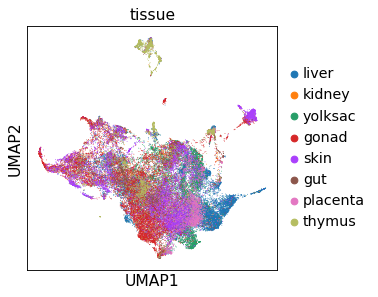

In [4]:
sc.pl.umap(adata, color = ['tissue'], save = '_tissue_raw.pdf')

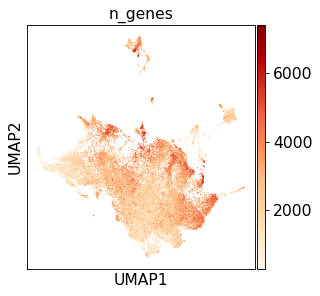

In [5]:
sc.pl.umap(adata, color = ['n_genes'], color_map = "OrRd", save = '_n_genes_raw.pdf')

#### Cluster the manifold 

In [22]:
gonads_colors = ['#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb', '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:16)


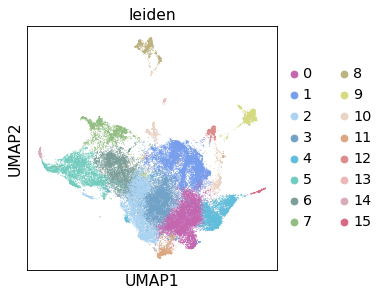

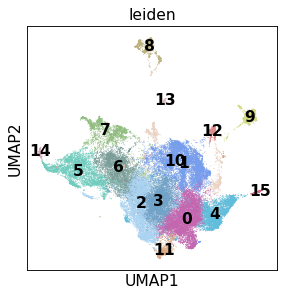

In [10]:
sc.tl.leiden(adata, resolution= 0.7)

sc.pl.umap(adata, color='leiden', palette = gonads_colors)
sc.pl.umap(adata, color='leiden', palette = gonads_colors, legend_loc='on data',save='_clustering_clusnumbers.pdf')

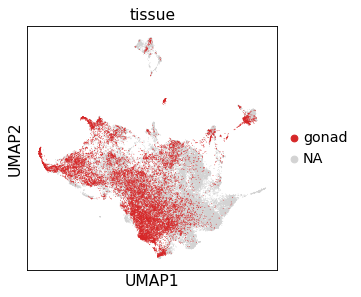

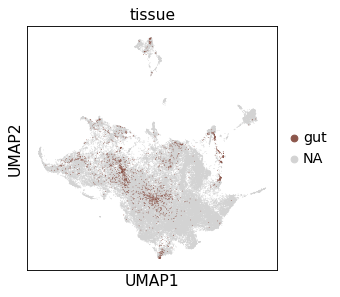

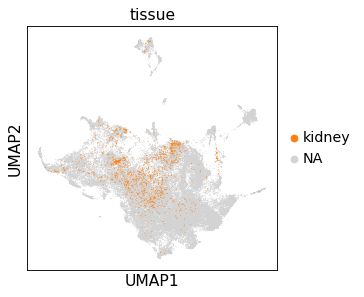

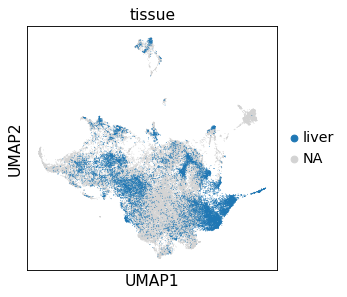

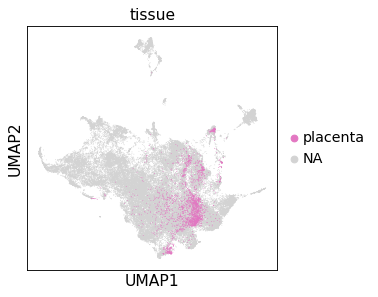

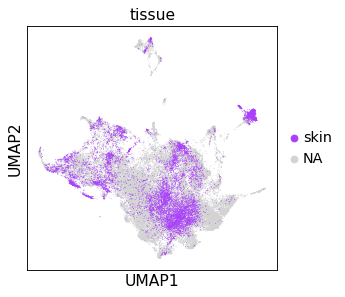

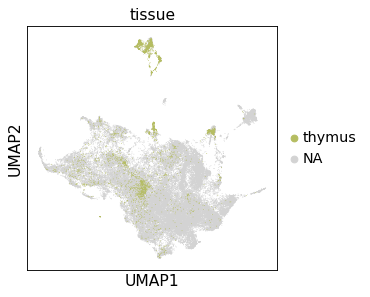

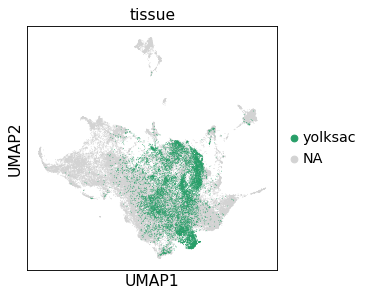

In [11]:
# Visualize distribution of cells from each tissue in the UMAP 
for t in np.unique(adata.obs['tissue']):
    sc.pl.umap(adata, color = 'tissue', groups = t)

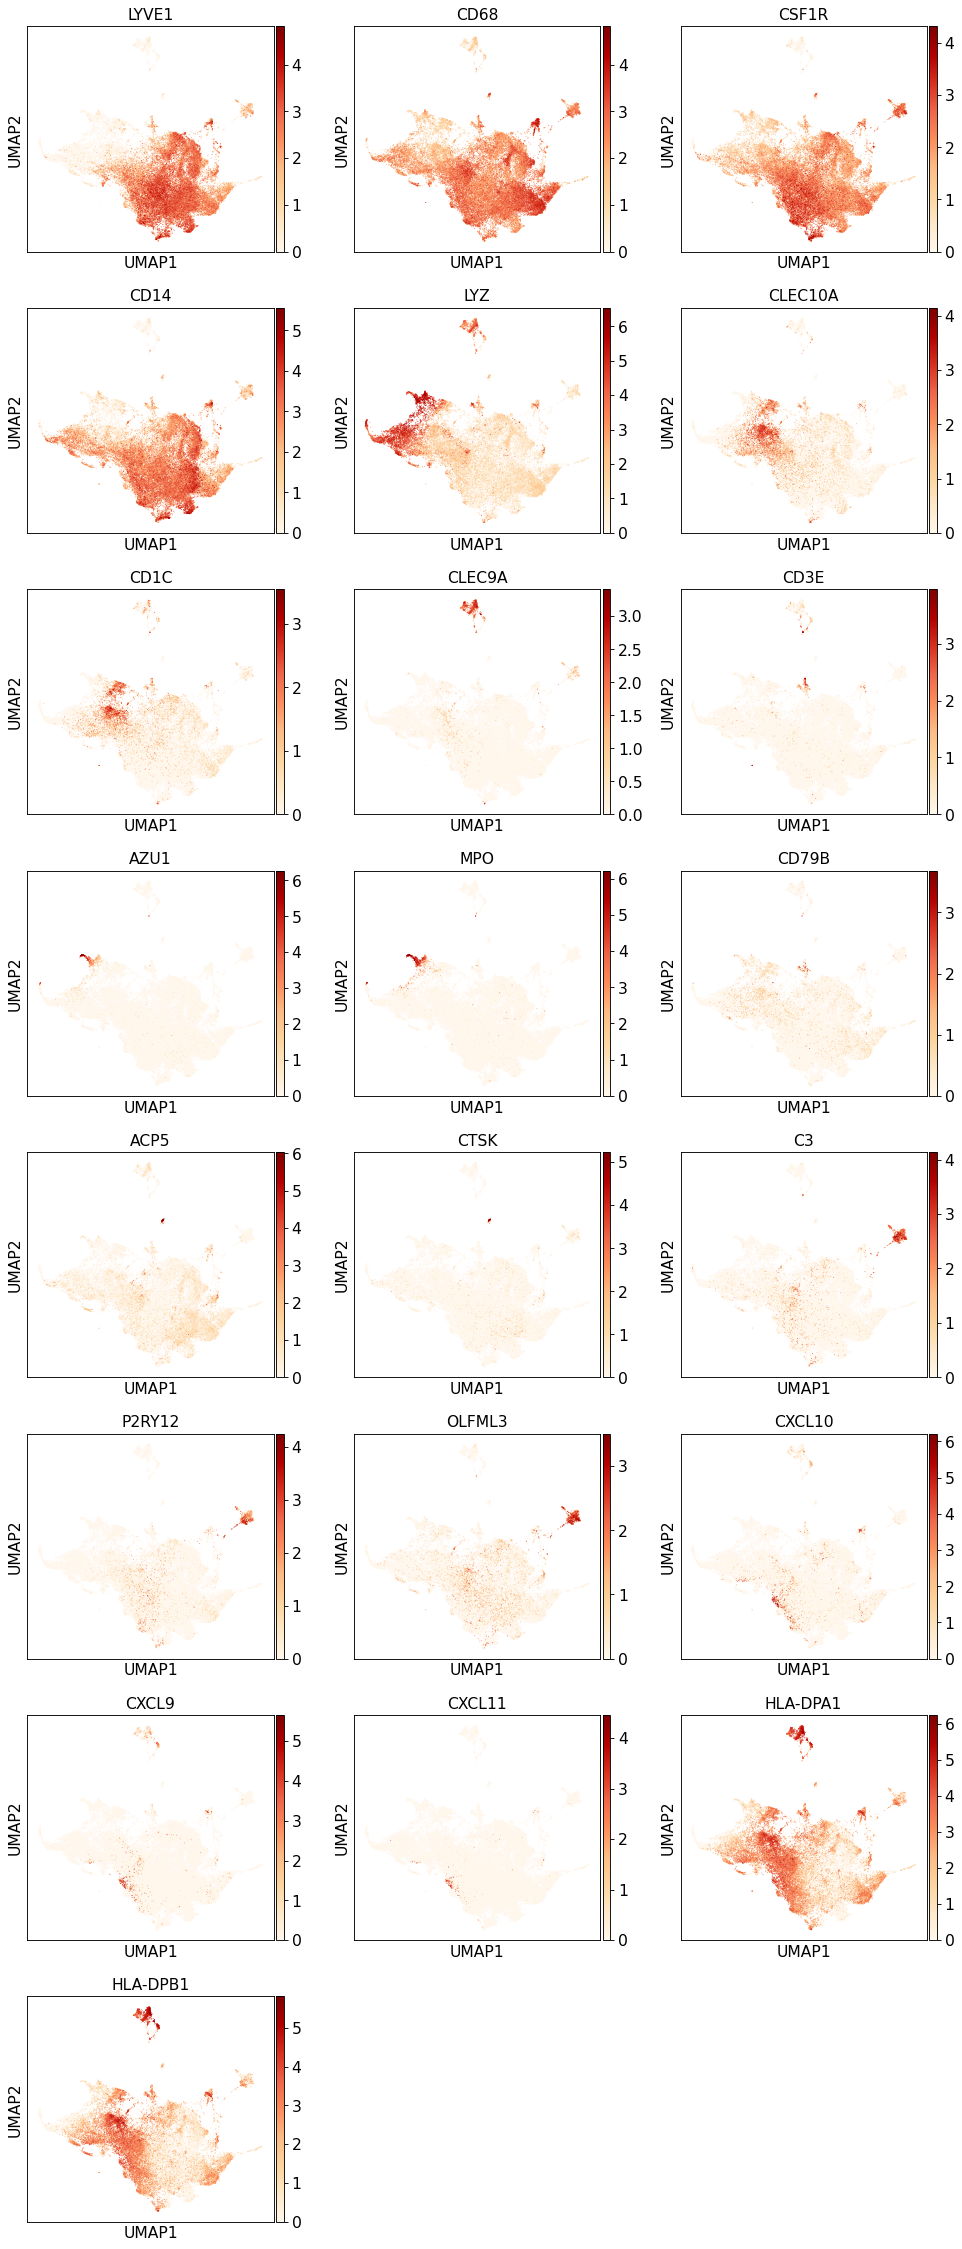

In [12]:
sc.pl.umap(adata, color = ['LYVE1', 'CD68', 'CSF1R', 'CD14', 'LYZ', 'CLEC10A', 'CD1C', 'CLEC9A', 
                          'CD3E',  'AZU1', 'MPO', 'CD79B', 'ACP5', 'CTSK', 'C3', 'P2RY12',
                           'OLFML3', 'CXCL10', 'CXCL9', 'CXCL11', 'HLA-DPA1', 'HLA-DPB1'], color_map = 'OrRd', ncols = 3, use_raw = True)

#### Assign cell states to clusters based on marker gene expression

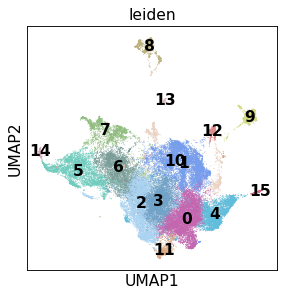

In [19]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

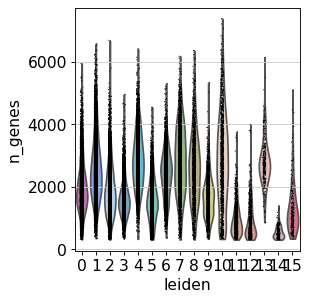

In [20]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'leiden')

In [21]:
#### Remove low quality clusters (no markers and low number of genes)
adata = adata[[i not in ['11', '12'] for i in adata.obs['leiden']]]
adata.shape

(52363, 55)

 * cDC2: 6
 * cDC1: 8 
 * osteoclast-like mac: 13 
 * microglia-like mac: 9 
 * erythroblastic island macro: 4, 15 
 * IFNg-induced macro: not a separate cluster
 * Mono: 5, 7, 14
 * tissue-repair macro: 0, 1, 2, 3, 10

In [7]:
annotations = {'6' : 'cDC2','8' : 'cDC1', '13' : 'SIGLEC15+ mac', 
              '9' : 'microglia-like mac', '4' : 'erythroblastic-island mac', '15' : 'erythroblastic-island mac',
               '7' : 'mono', '5' : 'mono', '14' : 'mono', 
              '0' : 'tissue-repair mac', '1' : 'tissue-repair mac', '2' : 'tissue-repair mac', 
              '3' : 'tissue-repair mac', '10' : 'tissue-repair mac'}
adata.obs['myeloid_atlas_clusters'] = adata.obs['leiden'].map(annotations)
adata.obs['myeloid_atlas_clusters'].value_counts(dropna = False)

tissue-repair mac            31930
mono                          7323
erythroblastic-island mac     4942
cDC2                          4572
cDC1                          1664
microglia-like mac            1648
SIGLEC15+ mac                  284
Name: myeloid_atlas_clusters, dtype: int64

In [8]:
adata.obs['myeloid_atlas_clusters'] = adata.obs['myeloid_atlas_clusters'].astype("category")
adata.obs['myeloid_atlas_clusters'] = adata.obs['myeloid_atlas_clusters'].cat.reorder_categories(['mono', 
                                                    'cDC1', 'cDC2', 'erythroblastic-island mac', 'tissue-repair mac', 
                                                    'microglia-like mac', 'SIGLEC15+ mac'])

In [35]:
gonads_colors_reduced = [ '#c466b0', '#779eed', '#aad3f2', '#70ccbe', 
                  '#d9abb7',  '#bdb380',  '#d4db81', 
                  '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb' ]

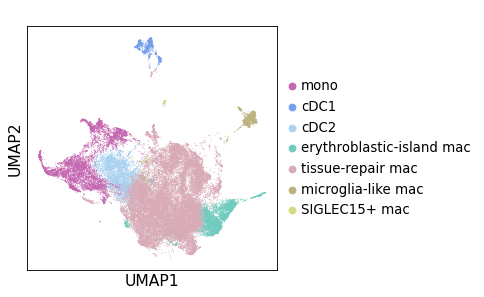

In [36]:
sc.pl.umap(adata, color = 'myeloid_atlas_clusters', palette = gonads_colors_reduced, 
           save = '_clusters.pdf',  frameon = True, title = " ",
           legend_fontweight = 'medium', legend_fontsize = 12)

#### Dotplot with main markers per cluster

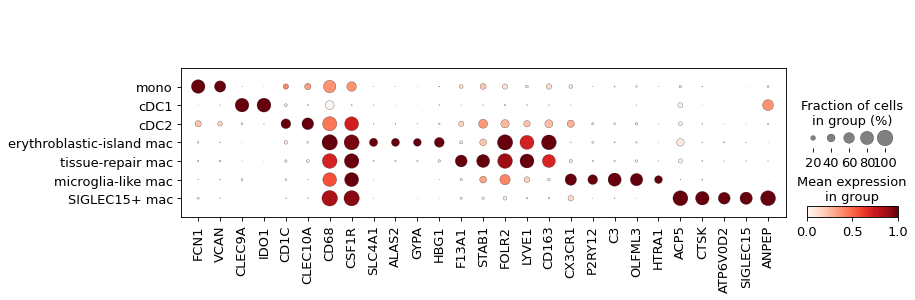

In [12]:
sc.pl.dotplot(adata, var_names = ['FCN1', 'VCAN',  'CLEC9A', 'IDO1', 'CD1C', 'CLEC10A',
                                        'CD68', 'CSF1R', 'SLC4A1', 'ALAS2', 'GYPA', 'HBG1',
                                  'F13A1', 'STAB1', 'FOLR2', 'LYVE1', 'CD163',
 
          'CX3CR1', 'P2RY12', 'C3', 'OLFML3', 'HTRA1',   
          'ACP5', 'CTSK', 'ATP6V0D2', 'SIGLEC15', 'ANPEP'], 
              groupby = 'myeloid_atlas_clusters',  use_raw = True, standard_scale = 'var', save = '_markers.pdf')

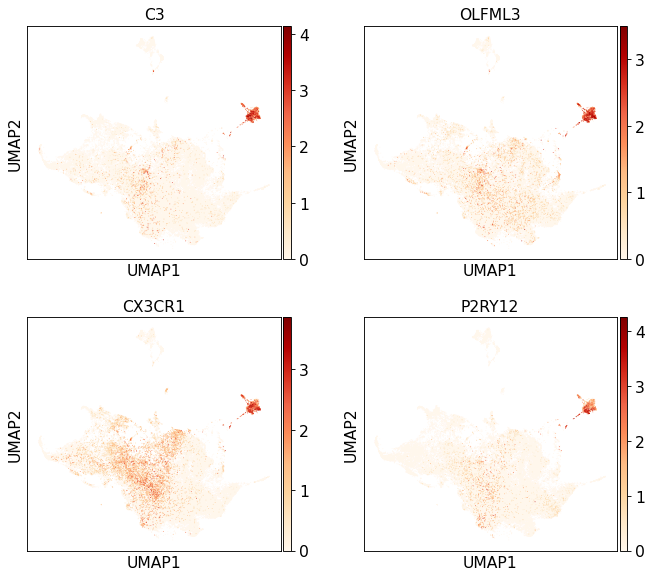

In [55]:

sc.pl.umap(adata, color = ['C3', 'OLFML3', 'CX3CR1', 'P2RY12'], ncols = 2, color_map = 'OrRd', save = '_microglia.pdf')

In [11]:
gonads_colors = ['#c466b0',  '#60bddb', '#e64e74','#edb7b7','#ebd3c3' , '#779eed', '#7b9e99',   '#70ccbe', 
               '#7b9e99', '#edb7b7', '#91bd80', '#d9a5c3','#cc8fdb', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#d9abb7','#aad3f2', '#e64e74',  ]

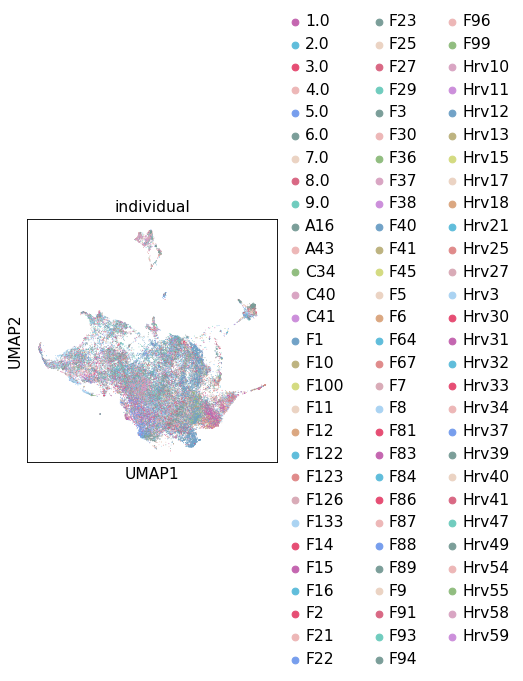

In [5]:
sc.pl.umap(adata, color='individual',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_individual.pdf', palette = gonads_colors)

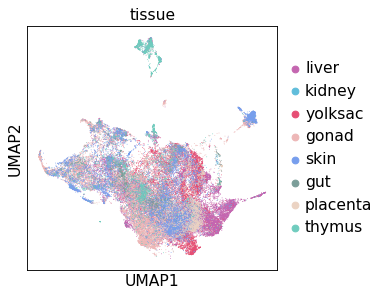

In [8]:
sc.pl.umap(adata, color='tissue',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_tissue.pdf', palette = gonads_colors)

#### Visualize barplot of cell states per tissue

In [56]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
       plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

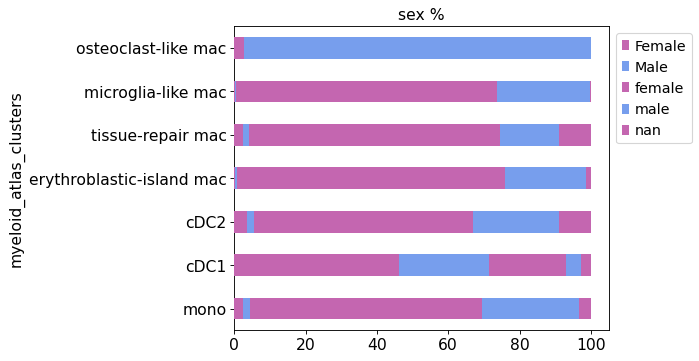

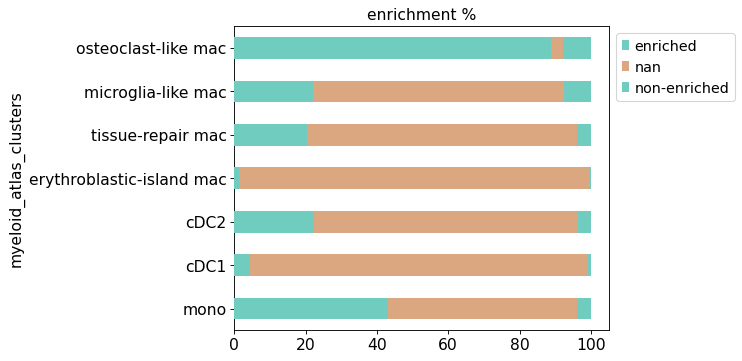

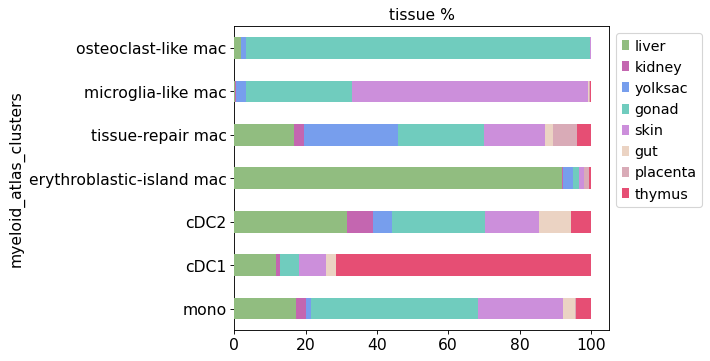

In [57]:
Barplot('sex', adata, var='myeloid_atlas_clusters', height=5, color = ['#c466b0', '#779eed'])
Barplot('enrichment', adata, var='myeloid_atlas_clusters', height=5, color = ['#70ccbe', '#dba781'])
Barplot('tissue', adata, var='myeloid_atlas_clusters', height=5, color = ['#91bd80', '#c466b0', '#779eed',  '#70ccbe', '#cc8fdb', 
                '#ebd3c3',  
                '#d9abb7',  '#e64e74', '#f092c4', '#ff4a4a', '#ffa44a', '#ffcc4a',
                                                          '#fff04a', '#98d16d', '#59a86e', '#119979',
                                                          '#34b6c2', '#349cc2', '#347bc2', '#185ea3', 
                                                          '#1e1585'])

#### Save

In [13]:
adata.write(path_to_results +  'fetal_myeloid_atlas_scVI_annotated.h5ad')

In [6]:
adata = sc.read(path_to_results +  'fetal_myeloid_atlas_scVI_annotated.h5ad')

### Visualize predictions from SVM model and scmap similarity scores from Bian et al., 2020

In [14]:
scmap = pd.read_csv(path_to_results + 'scmap_from_Bian.csv', index_col = 0)
scmap.shape

(11616, 2)

In [15]:
scmap = scmap.rename({'scmap_labels' : 'projection by scmap'}, axis = 1)

In [16]:
for col in scmap: 
    mapping = scmap[col].to_dict()
    adata.obs[col] = adata.obs_names.map(mapping)

In [17]:
cols = ['#d96884']

... storing 'projection by scmap' as categorical


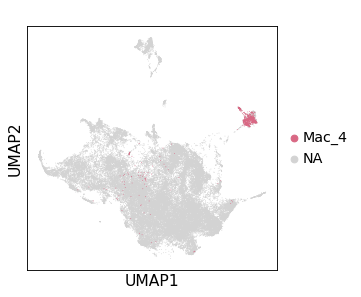

In [18]:
sc.pl.umap(adata, color = 'projection by scmap', groups = 'Mac_4', 
           title = " ", palette = cols, frameon = True, save = '_scmap.pdf')

In [19]:
svm = pd.read_csv(path_to_results + '_SVM_predictions_Bian.csv', index_col = 0)
svm.head()

,prob_EMP,prob_ErP,prob_GMP,prob_HSPC,prob_ILC,prob_LMP,prob_Lymphoblast,prob_Mac_1,prob_Mac_2,prob_Mac_3,prob_Mac_4,prob_MkP,prob_Myeloblast
FCAImmP7179363_AAACCTGAGGGTTTCT-liver,0.023878,0.029180,0.005523,0.032899,0.002677,0.039964,0.007003,0.004342,0.039786,0.004332,0.003112,0.007566,0.021790
FCAImmP7179363_AAACGGGCAACTGCTA-liver,0.026797,0.047706,0.015057,0.114786,0.014330,0.215800,0.139679,0.054639,0.126453,0.085741,0.017224,0.007537,0.008112
FCAImmP7179363_AAACGGGCAAGTCTGT-liver,0.012469,0.025369,0.010104,0.018169,0.010656,0.624236,0.058971,0.010796,0.036833,0.048886,0.010815,0.005428,0.005691
FCAImmP7179363_AAAGATGCAGGTCCAC-liver,0.036279,0.073223,0.066111,0.112560,0.009084,0.241125,0.034426,0.016771,0.096113,0.039634,0.010550,0.007086,0.029850
FCAImmP7179363_AAAGTAGAGTGCCATT-liver,0.067887,0.036041,0.019429,0.085990,0.008002,0.032271,0.037228,0.052633,0.135160,0.085344,0.030951,0.006640,0.021560


In [20]:
for col in svm: 
    mapping = svm[col].to_dict()
    adata.obs[col] = adata.obs_names.map(mapping)

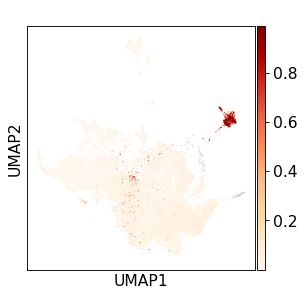

In [21]:
sc.pl.umap(adata, color = 'prob_Mac_4', title = ' ', 
           color_map = 'OrRd', frameon = True, save = '_pred_bian_SVM.pdf')

#### TF-IDF on clean manifold

In [37]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [38]:
import anndata
adata = anndata.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)

In [39]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 22430 52363 
metadata(0):
assays(1): X
rownames(22430): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(559): n_cells.0.gonad n_cells.1.gonad ... n_cells.yolksac
  n_counts
colnames(52363): FCAImmP7179363_AAACCTGAGGGTTTCT-liver
  FCAImmP7179363_AAACGGGAGTGAATTG-liver ...
  4861STDY7462257_TAGTGGTAGATATACG-thymus
  4861STDY7462257_TCAGCTCCACCTGGTG-thymus
colData names(89): Run Run2 ... prob_MkP prob_Myeloblast
reducedDimNames(0):
altExpNames(0):


In [40]:
%%R -o mrks

library(SoupX)
counts <- assay(adata, "X")
colnames(counts) <- colnames(adata)
rownames(counts) <- rownames(adata)
mrks = quickMarkers(counts, colData(adata)$myeloid_atlas_clusters, N = 100) # where clusters is the cell type assignment and 20 means I want the top 20 genes per cluster that pass the hypergeometric test

In [41]:
mrks.to_csv("/home/jovyan/MyeloidAtlas_markersTFIDF.csv")